In [ ]:
pip install --upgrade qiskit qiskit-machine-learning qiskit-optimization


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from qiskit_machine_learning.algorithms import VQR
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA

In [ ]:
# 1. Load the dataset
dataset_path = r"/content/tablea1.csv"  # Update the path to your dataset
data = pd.read_csv(dataset_path)

In [ ]:
# 2. Define the target and feature columns
target_column = 'logsigmae'
feature_columns = [
    'logM1/2', 'logRe', 'logAge', '[Z/H]', 'logM*/L', 'DlogAge', 'D[Z/H]', 'DlogM*/L'
]

In [ ]:
X = data[feature_columns]
y = data[target_column]

In [ ]:
# 3. Handle missing values by replacing them with the mean of the column
X.fillna(X.mean(), inplace=True)
y.fillna(y.mean(), inplace=True)

<ipython-input-10-475226060d74>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)


In [ ]:
# 4. Normalize the features using Min-Max normalization
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)


In [ ]:
# Normalize the target using Min-Max normalization
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

In [ ]:
# 5. Reduce the number of features using PCA (retain the number of components as 4)
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

In [ ]:
# 6. Perform 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

In [ ]:
mse_scores = []
mae_scores = []
r2_scores = []
rmse_scores = []

accuracy_mae_scores = []
accuracy_mse_scores = []
accuracy_rmse_scores = []

In [ ]:
for train_index, test_index in kf.split(X_pca):
    X_train, X_test = X_pca[train_index], X_pca[test_index]
    y_train, y_test = y_scaled[train_index], y_scaled[test_index]

    # 7. Define the quantum circuit
    num_qubits = 4  # Set number of qubits to 4
    feature_map = ZZFeatureMap(feature_dimension=num_qubits)
    ansatz = RealAmplitudes(num_qubits=num_qubits, reps=2)  # Increased repetitions for more complexity

    # 8. Define the VQR model with COBYLA optimizer
    vqr = VQR(
        num_qubits=num_qubits,
        feature_map=feature_map,
        optimizer=COBYLA(maxiter=100) ,  # Increased number of iterations
        ansatz=ansatz
    )

    # 9. Fit the model
    vqr.fit(X_train, y_train)

    # 10. Make predictions and evaluate the model
    y_pred = vqr.predict(X_test)

    # Calculate evaluation metrics for this fold
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)

    mse_scores.append(mse)
    mae_scores.append(mae)
    r2_scores.append(r2)
    rmse_scores.append(rmse)

    # Calculate accuracy based on error metrics
    accuracy_mae = 100 * (1 - mae / np.mean(y_test))
    accuracy_mse = 100 * (1 - mse / np.mean(y_test**2))
    accuracy_rmse = 100 * (1 - rmse / np.mean(y_test))

    accuracy_mae_scores.append(accuracy_mae)
    accuracy_mse_scores.append(accuracy_mse)
    accuracy_rmse_scores.append(accuracy_rmse)

In [ ]:
# 11. Print overall performance metrics
print("MSE Scores:", mse_scores)
print("MAE Scores:", mae_scores)
print("R^2 Scores:", r2_scores)
print("RMSE Scores:", rmse_scores)
print("Accuracy (MAE):", accuracy_mae_scores)
print("Accuracy (MSE):", accuracy_mse_scores)
print("Accuracy (RMSE):", accuracy_rmse_scores)

MSE Scores: [0.050400721121697425, 0.1114113692231765, 0.04977401454375967]
MAE Scores: [0.18361084994057333, 0.276550420504862, 0.17275233596091868]
R^2 Scores: [-0.06845240484471082, -1.5402081414457807, -0.13415378661773203]
RMSE Scores: [0.22450104926636183, 0.33378341663895844, 0.22310090664038026]
Accuracy (MAE): [66.71876570594353, 48.919744364722526, 69.279053046092]
Accuracy (MSE): [85.66283216570692, 66.93800697203136, 86.17767468397423]
Accuracy (RMSE): [59.30702340132103, 38.34852169955541, 60.32545041927286]


In [ ]:
!pip install lime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=784c3b8648a4a7547a64c39e57a6aff4fc854a3af4656eb86bef1d0a64790eec
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

# Create the LIME explainer
explainer = LimeTabularExplainer(
    training_data=X_train,  # Use the training data to train the explainer
    feature_names=feature_columns,  # Feature names from the dataset
    class_names=['logsigmae'],  # Target variable
    mode='regression',  # Specify this is a regression problem
    discretize_continuous=True  # Discretize continuous variables
)

# Select a sample to explain
sample_index = 0  # Change this index for different samples
explanation = explainer.explain_instance(
    X_test[sample_index],  # Pick the instance from the test set
    vqr.predict,  # Model's predict function
    num_features=5  # Number of features to display in the explanation
)

# Display the explanation
explanation.show_in_notebook()


In [ ]:
!pip install shap


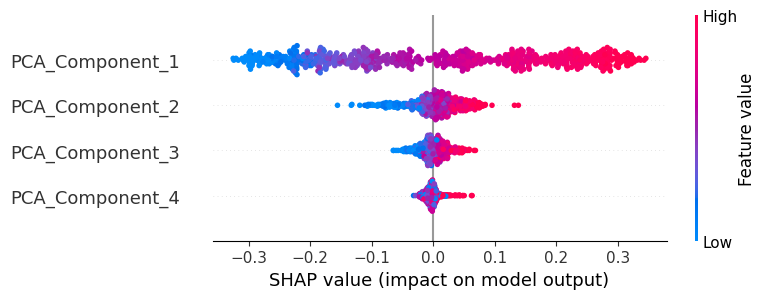

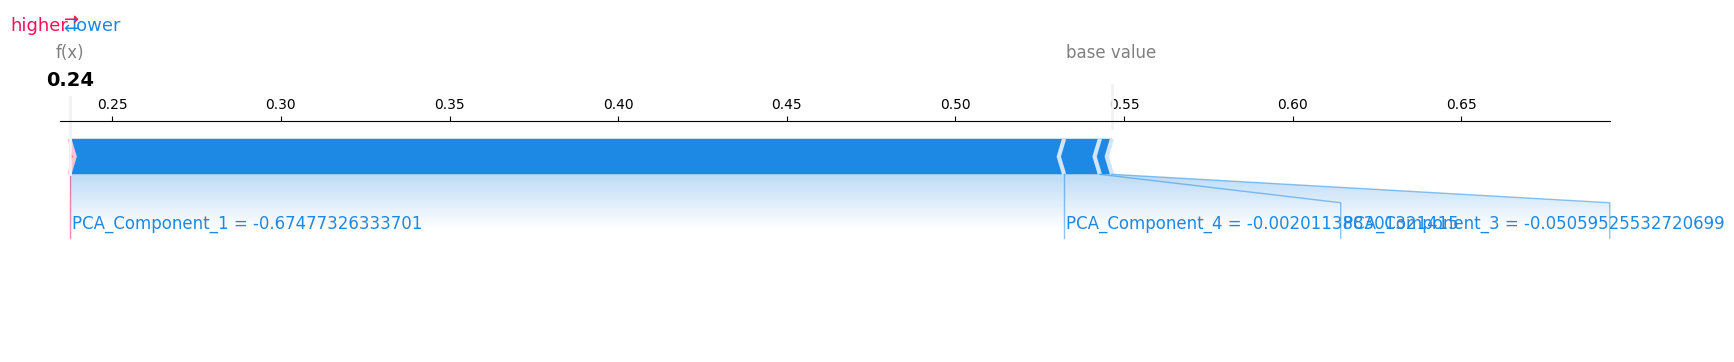

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Train a surrogate RandomForestRegressor model on the same training data
surrogate_model = RandomForestRegressor(random_state=42)
surrogate_model.fit(X_train, y_train)

# Use SHAP's TreeExplainer for the surrogate model
explainer = shap.TreeExplainer(surrogate_model)

# Explain the predictions for the test set
shap_values = explainer.shap_values(X_test)

# Define feature names for PCA components
pca_feature_names = [f"PCA_Component_{i+1}" for i in range(X_pca.shape[1])]

# Convert test data to DataFrame for visualization
X_test_df = pd.DataFrame(X_test, columns=pca_feature_names)

# Plot SHAP summary plot
shap.summary_plot(shap_values, X_test_df, feature_names=pca_feature_names)

# SHAP force plot for a specific test sample (e.g., the first test sample)
shap.force_plot(
    explainer.expected_value,
    shap_values[0],  # SHAP values for the first test sample
    X_test_df.iloc[0],  # Feature values of the first test sample
    feature_names=pca_feature_names,
    matplotlib=True
)
